In [1]:
import csv
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({"font.size": 10})
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = True

# plt.rcParams["axes.facecolor"] = "#f5f5f5"
plt.rcParams["grid.color"] = "white"
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.linewidth"] = 2

def load_price_data(path_to_data_dir="../data/",price_file="eth_usd_price"):
    with open(path_to_data_dir+price_file+".csv","r") as infile:
        try:
            df = pd.read_csv(infile)
            print(df.shape)
        except Exception as e:
            print(e)

    df['datetime'] = pd.to_datetime(df['unix_timestamp'], unit='s')    
    df.sort_values(by="unix_timestamp", axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
    df['date'] = df['datetime'].dt.date
    return(df)

def process_daily_summary(price_data):
    price_data["weighted_avg"] = price_data["volume"]*price_data["close"]    
    price_data['volatility'] = price_data['close'].pct_change()
    
    daily_price_data = price_data.groupby("date").agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum",
        "unix_timestamp": "first",
        "weighted_avg": "sum",
        "volatility": "sum",
        })
    
    daily_price_data["weighted_avg"] = daily_price_data["weighted_avg"]/daily_price_data["volume"]
    return(daily_price_data)

def price_analysis(daily_price_data,price_file = "usdt_usdc_price",
                   jump_threshold=.04,recovery_mean=None,recovery_threshold=0.005,
                   trunc_window_start=None,trunc_window_end=None):        
    #### Compute GBM Mu and Sigma
    daily_price_data['daily_return'] = daily_price_data['weighted_avg'].pct_change()
    daily_price_data['log_daily_return'] = np.log(daily_price_data['weighted_avg'] / daily_price_data['weighted_avg'].shift(1))

    # Drop NaN values (the first entry will be NaN due to the shift)
    daily_price_data = daily_price_data.dropna()

    # Calculate mean (mu) and standard deviation (sigma) of daily returns
    mu = daily_price_data['log_daily_return'].mean()
    sigma = daily_price_data['log_daily_return'].std()

    print("Mean (mu) of daily returns:", mu)
    print("Standard deviation (sigma) of daily returns:", sigma)

    # plt.figure()
    # plt.plot(daily_price_data["weighted_avg"])

    #### Jump Diffusion - Magnitude Analysis
    daily_price_data["drops"]=(daily_price_data["high"]-daily_price_data["low"])/daily_price_data["weighted_avg"]
    counts,bin_edges = np.histogram(daily_price_data["drops"],bins=100)
    hist_daily_df = pd.DataFrame({"Bin_Left_Edge":bin_edges[:-1],"Bin_Reft_Edge":bin_edges[1:],"Count":counts})
    # plt.figure()
    # plt.hist(daily_price_data["drops"],bins=100,log=True)
    # plt.title('Main Title')
    # plt.xlabel('Drop Size (%)')
    # plt.ylabel('# Days')
    # plt.show()

    #### Jump Diffusion - Recovery Analysis     
    recovery_times = []
    jump_state = False
    jump_timer=0    

    daily_price_data["jump_state"]=False
    daily_price_data["recovery_mean"]=recovery_mean    
    daily_price_data["ema"]=daily_price_data["weighted_avg"].ewm(span=9, adjust=False).mean()

    for index, row in daily_price_data.iterrows():    
        jump_clear = abs(row["daily_return"])>=jump_threshold
        
        if recovery_mean==None:            
            daily_price_data.loc[index,"recovery_mean"] = daily_price_data.loc[index,"ema"]
        in_recovery_range = abs(daily_price_data.loc[index,"recovery_mean"]-row["weighted_avg"])<daily_price_data.loc[index,"recovery_mean"]*recovery_threshold
        
        if jump_state==True:
            jump_timer+=1
            if in_recovery_range:
                recovery_times+=[jump_timer]
                jump_state=False
                jump_timer=0    
            else:
                pass
        else: 
            if jump_clear:
                jump_state=True
            else:
                pass    
        daily_price_data.loc[index, "jump_state"] = jump_state

    # plt.figure()
    # plt.plot(daily_price_data["daily_return"])
    # plt.axhline(y=jump_threshold, color='r', linestyle='--')
    # plt.axhline(y=-1*jump_threshold, color='r', linestyle='--')

    daily_price_data.index = pd.to_datetime(daily_price_data.index)
    
    if trunc_window_start!=None and trunc_window_end!=None:
        trunc_daily_price_data = daily_price_data[(daily_price_data.index>=trunc_window_start) & (daily_price_data.index<=trunc_window_end)]
    else:
        trunc_daily_price_data = daily_price_data

    return trunc_daily_price_data

def plot_jumps(df, recovery_threshold, fn=None):
    f, ax = plt.subplots(figsize=(8, 5))
    
    ax.plot(df["weighted_avg"], color = 'royalblue', lw=1, label='WAVG Price')
    ax.plot(df["recovery_mean"]*(1+recovery_threshold), color='black', linestyle='--', lw=1, label='Recovery Threshold')
    ax.plot(df["recovery_mean"]*(1-recovery_threshold), color='black', linestyle='--', lw=1)
    ax.set_ylabel('ETH Price (USD)')
    ax.set_title('Detecting ETH Jumps')

    for i, row in df.iterrows():
        left_edge = i - pd.to_timedelta(.5, unit='D')
        right_edge = i + pd.to_timedelta(.5, unit='D')
        if row['jump_state'] == True: 
            ax.axvspan(left_edge, right_edge, color="indianred")

    ax.axvspan(None, None, color='indianred', label='Jump')
    ax.tick_params(axis='x', rotation=45)
    
    f.legend(loc="upper center", bbox_to_anchor=(0.5, 0), ncol=3)
    f.tight_layout()

    if fn:
        f.savefig(fn, bbox_inches="tight", dpi=300)
        plt.close()  # don't show

    return f

In [4]:
#### Stablecoin Price Analysis
price_file="usdt_usdc_price"
price_data = load_price_data(path_to_data_dir="../data/",price_file=price_file)
daily_price_data = process_daily_summary(price_data)
df = price_analysis(daily_price_data,price_file=price_file,
               jump_threshold = .04,recovery_mean = 1,recovery_threshold = 0.01,
               trunc_window_start=datetime.datetime(2023, 3, 1),
               trunc_window_end=datetime.datetime(2023, 3, 30))

(14656, 8)
Mean (mu) of daily returns: 2.1037989538991367e-07
Standard deviation (sigma) of daily returns: 0.003190873414000883


/var/folders/3r/4cwkccx9163_2pw62tzw8jwh0000gn/T/ipykernel_95349/3446294840.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_price_data["drops"]=(daily_price_data["high"]-daily_price_data["low"])/daily_price_data["weighted_avg"]
/var/folders/3r/4cwkccx9163_2pw62tzw8jwh0000gn/T/ipykernel_95349/3446294840.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_price_data["jump_state"]=False
/var/folders/3r/4cwkccx9163_2pw62tzw8jwh0000gn/T/ipykernel_95349/3446294840.py:87: SettingWithCopyWarning: 

In [6]:
#### ETH Price Analysis
price_file="eth_usd_price"
price_data = load_price_data(path_to_data_dir="../data/",price_file=price_file)
daily_price_data = process_daily_summary(price_data)
df = price_analysis(daily_price_data,price_file=price_file,
               jump_threshold = .1,recovery_mean = None,recovery_threshold = 0.05,
               trunc_window_start=None,
               trunc_window_end=None)

(16048, 8)
Mean (mu) of daily returns: -0.0010887960696717581
Standard deviation (sigma) of daily returns: 0.03125021914966718


/var/folders/3r/4cwkccx9163_2pw62tzw8jwh0000gn/T/ipykernel_95349/3446294840.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_price_data["drops"]=(daily_price_data["high"]-daily_price_data["low"])/daily_price_data["weighted_avg"]
/var/folders/3r/4cwkccx9163_2pw62tzw8jwh0000gn/T/ipykernel_95349/3446294840.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_price_data["jump_state"]=False
/var/folders/3r/4cwkccx9163_2pw62tzw8jwh0000gn/T/ipykernel_95349/3446294840.py:87: SettingWithCopyWarning: 

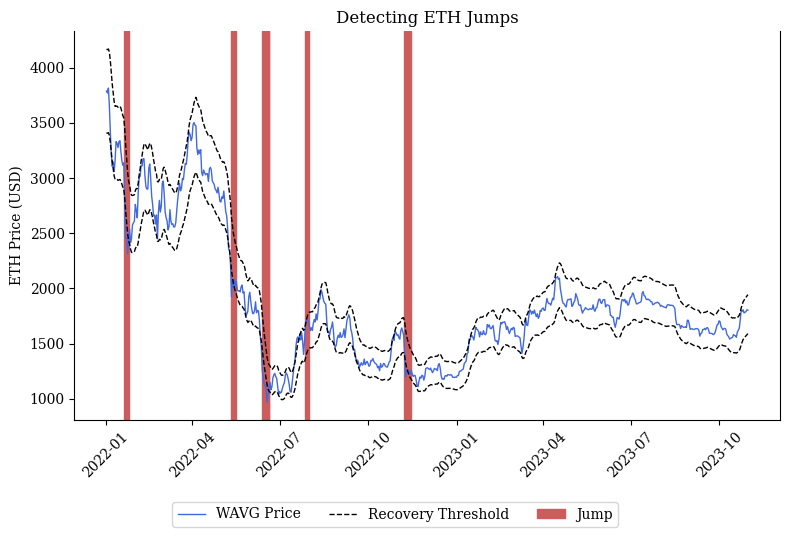

In [8]:
plot_jumps(df, 0.1, '../figs/manual/eth_jumps.png')

In [9]:
### ETH and BTC Covariance Analysis from Coinbase

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#### Read in ETH and BTC Price Data

with open("../data/BTC-USD_price_86400_1641013200_to_1699315200.csv", "r") as infile:
    cb_btc_data = pd.read_csv(infile)

with open("../data/ETH-USD_price_86400_1641013200_to_1699315200.csv", "r") as infile:
    cb_eth_data = pd.read_csv(infile)

# Merge the data on the 'unix_timestamp' column
cb_price_data = pd.merge(cb_btc_data, cb_eth_data, on="unix_timestamp", how="inner")
cb_price_data.rename(columns={"datetime_x": "datetime", "close_x": "BTC", "close_y": "ETH"}, inplace=True)
cb_price_data['datetime'] = pd.to_datetime(cb_price_data['datetime'])  # Convert to datetime
cb_price_data['BTC_norm'] = cb_price_data['BTC'] / cb_price_data['BTC'].max()
cb_price_data['ETH_norm'] = cb_price_data['ETH'] / cb_price_data['ETH'].max()

### Plot ETH and BTC Coinbase Prices

# Set global rcParams for font and spine visibility
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 10
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = True  # Enable the right spine

# Set additional plot styling
plt.rcParams["grid.color"] = "grey"
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 0.5

# Create the figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot BTC actual prices with label for the legend
ax1.plot(cb_price_data['datetime'], cb_price_data['BTC'], label='BTC Price', color='orange')

# Set labels and title for the first y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Price', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

# Create a second y-axis for the ETH prices
ax2 = ax1.twinx()

# Plot ETH actual prices with label for the legend
ax2.plot(cb_price_data['datetime'], cb_price_data['ETH'], label='ETH Price', color='blue')

# Set the label for the second y-axis
ax2.set_ylabel('ETH Price', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Formatting dates on the x-axis
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)  # Rotate dates for better spacing

# Add title
ax1.set_title('Coinbase BTC and ETH Prices Over Time')

# Enable the grid
ax1.grid(True)

# Add a legend to the plot
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust the subplot to fit the figure area
plt.tight_layout()

# Show the plot
plt.show()


#### Compute Correlation Coefficient using Pearson method
corr = cb_price_data["BTC"].corr(cb_price_data['ETH'],method='pearson')  # 'pearson' is the default method
print(f"The correlation coefficient between BTC and ETH is: {corr}")


#### Price Generator
import sys
sys.path.insert(0, '../')
from src.sim.pricegenerator import PriceGenerator
T = 1
dt = 1/(365*24)

price_generator = PriceGenerator()

####### config2

with open("../src/sim/configs/config_2.json","r") as infile:
    config = json.load(infile)

title = config["title"]  # Title for the simulation, possibly used in plots or reporting
assets = config["assets"]  # List of asset identifiers to simulate
type = config["type"]  # Type of simulation to perform

if type[0] == "multi_corr":
    sparse_cor = config["sparse_cor"]
    assets = price_generator.gen_cor_jump_gbm2(assets, sparse_cor, T, dt)
else:
    sparse_cor = None
    assets = price_generator.gen_jump_gbm2(assets, T, dt)

price_generator.plot_gbms(T, dt, assets, title=title)

########## config3

with open("../src/sim/configs/config_3.json","r") as infile:
    config = json.load(infile)

title = config["title"]  # Title for the simulation, possibly used in plots or reporting
assets = config["assets"]  # List of asset identifiers to simulate
type = config["type"]  # Type of simulation to perform

if type[0] == "multi_corr":
    sparse_cor = config["sparse_cor"]
    assets = price_generator.gen_cor_jump_gbm2(assets, sparse_cor, T, dt)
else:
    sparse_cor = None
    assets = price_generator.gen_jump_gbm2(assets, T, dt)

price_generator.plot_gbms(T, dt, assets, title=title)

FileNotFoundError: [Errno 2] No such file or directory: '../data/BTC-USD_price_86400_1641013200_to_1699315200.csv'